# Object Recognition on the UMD Dataset

This notebook provides a demonstration on inferencing a one-shot object recognition model on the __[UMD part-affordance](https://users.umiacs.umd.edu/~fer/affordance/part-affordance-dataset/)__ dataset. You will need to generate a JSON annotation file for the dataset you want to use (refer to the __[README](../README.md/#generating-annotation-files)__ for additional details).


In [1]:
# import standard libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
torch.manual_seed(1)

# add root code directory to python path
current_dir = os.path.dirname(os.path.abspath(''))
print(f"[INFO] Adding '{current_dir}' to python path.")
sys.path.append(current_dir)

# import libraries from os_tog
import os_tog.model as m
import os_tog.dataset as d
from os_tog.config import ObjectRecognitionConfig as cfg
from os_tog.utils import visualize, plot_triplet

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[INFO] Adding 'd:\PhD Projects\OS_TOG (Github)' to python path.


## Loading a Dataset

The code below is used to generate dataset objects and data loaders, as well as preview some triplets from the dataset. This may take ~1min due to the amount of images in the dataset. This code uses the balanced batch sampler mentioned in the paper, however, you can train without it as well by replacing `batch_sampler=train_batch_sampler` to `batch_size=cfg.TRAIN_BATCH_SIZE`. It's recommend you shuffle the train dataloader too then.

In [2]:
# define transformations
def get_transform(train=True, observation=True, to_visualize=False):
    transforms = []
    if observation:
        if train:
            transforms.append(torchvision.transforms.RandomHorizontalFlip(p=0.7))
    transforms.append(d.ImgCustomCrop([120,30,520,430])) # (x1, y2, x2, y2)
    transforms.append(torchvision.transforms.Resize((224, 224))) 
    transforms.append(torchvision.transforms.ToTensor())
    if not to_visualize:
        transforms.append(torchvision.transforms.Normalize(cfg.NORM_MEAN, cfg.NORM_STD))
    return torchvision.transforms.Compose(transforms)

# create dataset objects (ADD_MASK adds masks to observations)
train_dataset = d.ObjectRecognitionDataset(
    cfg.UMD_PATH, 
    annotation_file=os.path.join(cfg.UMD_ANNOT_PATH, "UMD_category_training_annotations.json"), 
    transforms=get_transform(), 
    ref_transforms=get_transform(observation=False), 
    GE=cfg.GUIDED_EMBEDDINGS, 
    RP=cfg.RANDOM_PROD, 
    ADD_MASK=True
)
test_dataset = d.ObjectRecognitionDataset(
    cfg.UMD_PATH, 
    annotation_file=os.path.join(cfg.UMD_ANNOT_PATH, "UMD_category_testing_annotations.json"),
    split="testing",
    transforms=get_transform(train=False), 
    ref_transforms=get_transform(train=False, observation=False), 
    GE=cfg.GUIDED_EMBEDDINGS, 
    RP=cfg.RANDOM_PROD, 
    ADD_MASK=True
)

# (OPTIONAL) create special data loaders (balanced batch sampling) that loads X samples of N classes per batch
train_batch_sampler = d.ObjectRecognitionBatchSampler(train_dataset, n_classes=4, n_samples=5)
test_batch_sampler = d.ObjectRecognitionBatchSampler(test_dataset, n_classes=4, n_samples=5)

train_loader = torch.utils.data.DataLoader(
    train_dataset, num_workers=cfg.NUM_WORKERS, batch_sampler=train_batch_sampler)
test_loader = torch.utils.data.DataLoader(
    test_dataset, num_workers=cfg.NUM_WORKERS, batch_sampler=test_batch_sampler)

[INFO] Generating guided embeddings for each product image class...


100%|██████████| 54/54 [00:03<00:00, 14.04it/s]


[INFO] Finished generating guided embeddings.
[INFO] Generating guided embeddings for each product image class...


100%|██████████| 51/51 [00:01<00:00, 37.15it/s]

[INFO] Finished generating guided embeddings.


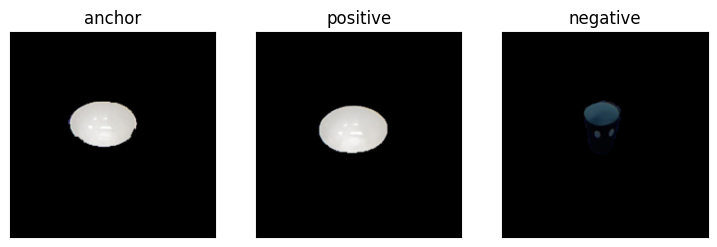

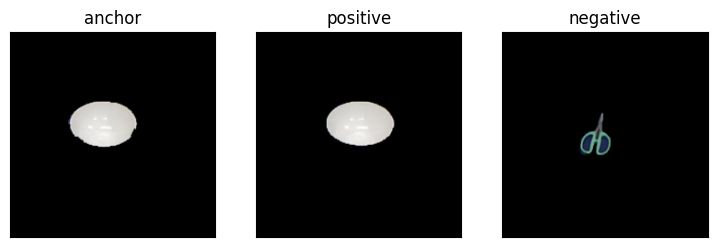

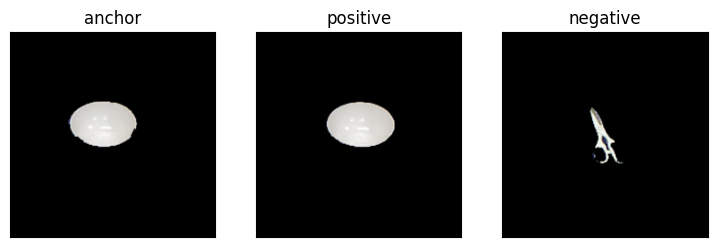

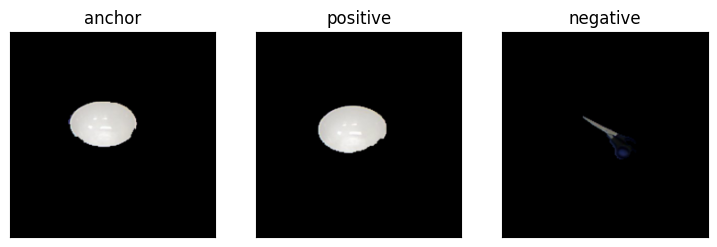

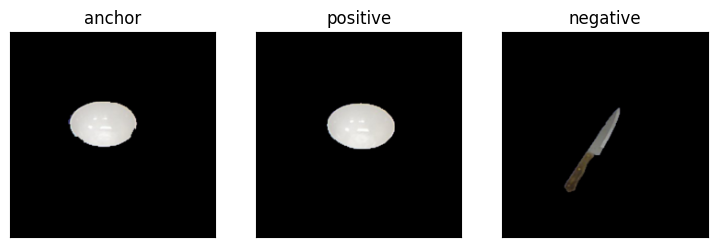

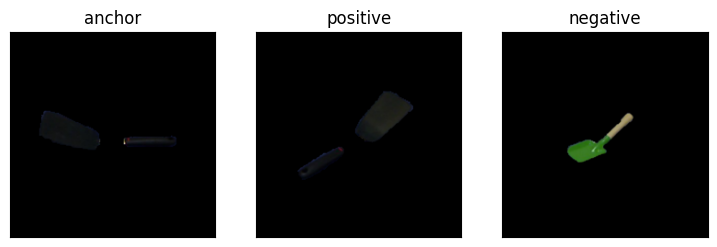

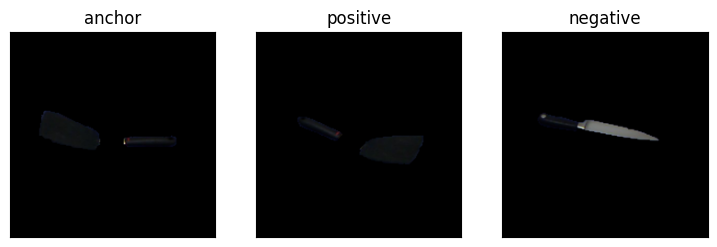

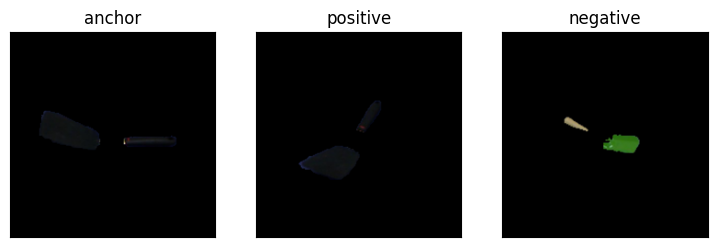

In [4]:
# change some settings for visualizing (i.e. without normalization and embedding vector)
train_dataset.GUIDED_EMBEDDINGS = False
train_dataset.transforms = get_transform(train=False, to_visualize=True) 
train_dataset.ref_transforms = get_transform(train=False, to_visualize=True) 
train_loader = torch.utils.data.DataLoader(
    train_dataset, num_workers=cfg.NUM_WORKERS, batch_sampler=train_batch_sampler)

img_triplet = next(iter(train_loader)) # get batch
anchor_img, pos_img, neg_img = img_triplet['anchor_img'], img_triplet['pos_img'], img_triplet['neg_img']
for batch_idx in range(len(anchor_img[:8])): # just show first 8 images
    plot_triplet(anchor_img[batch_idx], pos_img[batch_idx], neg_img[batch_idx])

# reset back to before for training
train_dataset.GUIDED_EMBEDDINGS = True
train_dataset.transforms = get_transform() 
train_dataset.ref_transforms = get_transform(observation=False) 
train_loader = torch.utils.data.DataLoader(
    train_dataset, num_workers=cfg.NUM_WORKERS, batch_sampler=train_batch_sampler)

## Building a Model

In [3]:
model = m.build_object_recognition_model(cfg)

In [4]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("[INFO] Total model params:", pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("[INFO] Total trainable params:", pytorch_total_params)

print("[INFO] Printing model...")
print(model)

[INFO] Total model params: 23508032
[INFO] Total trainable params: 23508032
[INFO] Printing model...
DataParallel(
  (module): TripletModel(
    (feature_extractor): FeatureExtractor(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1

## Training a Model

The code below can be used to training and evaluating the model for N epochs. It prints losses and saves the model at each epoch.

In [5]:
# set model to GPU for training
model.to(DEVICE)

# get model parameters
params = []
for _, value in dict(model.named_parameters()).items():
    if value.requires_grad:
        params += [{'params': [value]}]

# construct an optimizer
optimizer = torch.optim.SGD(params, lr=cfg.LEARNING_RATE, momentum=cfg.MOMENTUM)
criterion = torch.nn.MarginRankingLoss(margin=cfg.MARGIN)

train_hist = {}  # to store training and validation losses
for epoch in range(1, cfg.EPOCHS+1):
    # train + evaluate model for one epoch
    m.train_object_recognition_model(train_dataset, train_loader, model, criterion, optimizer, epoch, DEVICE, cfg)
    m.test_object_recognition_model(test_dataset, test_loader, model, criterion, epoch, DEVICE, cfg)
    m.save_model(model, cfg.MODEL_DIR, f"{cfg.MODEL_NAME}_{epoch}.pt")

  0%|          | 0/741 [00:00<?, ?it/s]

Training Epoch 1: 100%|██████████| 741/741 [02:05<00:00,  5.88it/s, acc=100, loss=0]       


Finished training epoch 1 - avg. train loss: 0.01838 and avg. train acc: 98.219


Validating Epoch 1: 100%|█████████▉| 700/701 [01:57<00:00,  5.97it/s, val_acc=90, val_loss=0.101]  


Finished validating epoch 1 - avg. test loss: 0.09354 and avg. test acc: 91.413
Test accuracy with diff = 0% of margin: 91.413
Test accuracy with diff = 20.0% of margin: 80.792
Test accuracy with diff = 50.0% of margin: 55.906
Test accuracy with diff = 100% of margin: 14.365
[INFO] Saving checkpoint '../models/object_recognition\triplet_UMD_masked_t1_1.pt'


Training Epoch 2: 100%|██████████| 741/741 [02:04<00:00,  5.94it/s, acc=100, loss=0]       


Finished training epoch 2 - avg. train loss: 0.00017 and avg. train acc: 100.000


Validating Epoch 2: 100%|█████████▉| 700/701 [01:52<00:00,  6.23it/s, val_acc=95, val_loss=0.0632] 


Finished validating epoch 2 - avg. test loss: 0.08501 and avg. test acc: 93.067
Test accuracy with diff = 0% of margin: 93.067
Test accuracy with diff = 20.0% of margin: 84.601
Test accuracy with diff = 50.0% of margin: 60.913
Test accuracy with diff = 100% of margin: 18.709
[INFO] Saving checkpoint '../models/object_recognition\triplet_UMD_masked_t1_2.pt'


Training Epoch 3: 100%|██████████| 741/741 [02:04<00:00,  5.94it/s, acc=100, loss=0]       


Finished training epoch 3 - avg. train loss: 0.00014 and avg. train acc: 100.000


Validating Epoch 3: 100%|█████████▉| 700/701 [01:52<00:00,  6.22it/s, val_acc=100, val_loss=0.08]  

Finished validating epoch 3 - avg. test loss: 0.07913 and avg. test acc: 93.274
Test accuracy with diff = 0% of margin: 93.274
Test accuracy with diff = 20.0% of margin: 85.193
Test accuracy with diff = 50.0% of margin: 63.816
Test accuracy with diff = 100% of margin: 22.361
[INFO] Saving checkpoint '../models/object_recognition\triplet_UMD_masked_t1_3.pt'


## Inferencing a Model

The code below is an example of inferencing the code on the UMD dataset to match each scene image to the nearest 5 object labels with the first being the nearest.

In [3]:
model = m.build_object_recognition_model(cfg)
model = m.load_model(model, '../models/object_recognition/triplet_UMD_masked_t1_3.pt')
model = model.module.feature_extractor
model.eval() # set model to evaluation mode
model.to(DEVICE);

# generate references
ref_features, ref_class, ref_img_idx = test_dataset.generate_references(model)

[INFO] Loading checkpoint '../models/object_recognition/triplet_UMD_masked_t1_3.pt'
[INFO] Loaded checkpoint '../models/object_recognition/triplet_UMD_masked_t1_3.pt'
[INFO] Generating product image features...


100%|██████████| 51/51 [00:01<00:00, 41.77it/s]


In [5]:
sample = test_dataset.__getitem__(2000)
scene_img = sample['pos_img'][None,:,:]
scene_img = scene_img.to(DEVICE)

pred_dists, pred_labels = m.inference_object_recognition_model(model, scene_img, ref_class, ref_features)
print(f"True Label: {sample['pos_label']} ({test_dataset.class_info[sample['pos_label']]})")
print(f"Predicted Labels: {[(i, test_dataset.class_info[i]) for i in pred_labels]}")

True Label: 16 (cup_06)
Predicted Labels: [(16.0, 'cup_06'), (14.0, 'cup_04'), (15.0, 'cup_05'), (42.0, 'mug_01'), (60.0, 'mug_19')]
